In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

# Loading 

## Load model

In [2]:
from keras.models import load_model
model = load_model("../models/model8_balanced.hd5")
scaler = pickle.load(open("../models/scaler.pkl", "rb"))

Using TensorFlow backend.
W0108 16:52:21.915545 139831690569536 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0108 16:52:21.959289 139831690569536 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0108 16:52:22.008568 139831690569536 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0108 16:52:22.010011 139831690569536 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch

## Load data
Seed is included

In [13]:
include_seed=True

In [14]:
datas_val = []

for i in range(80, 127):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/numpy_v3/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    #Seed included
    if include_seed:
        datas_val.append(d[(d.is_calo) ])
        # Seed not included
    else:
        datas_val.append(d[(d.is_calo) & (d.is_seed==False)])
        
data_val  = pd.concat(datas_val, ignore_index=True)

cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]


# Evaluation

In [15]:
data_val["y"] = model.predict(scaler.transform(data_val[cols].values), batch_size=2048)
data_out = data_val[data_val.in_scluster== False]
data_in = data_val[data_val.in_scluster == True]

### ROC

In [7]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve
y_test = np.array(data_val.in_scluster, dtype=int)
pred = data_val["y"].values
auc = roc_auc_score(y_test,pred)
print("AUC score: " + str(auc))


>>> Computing AUC...
AUC score: 0.9969654929127219


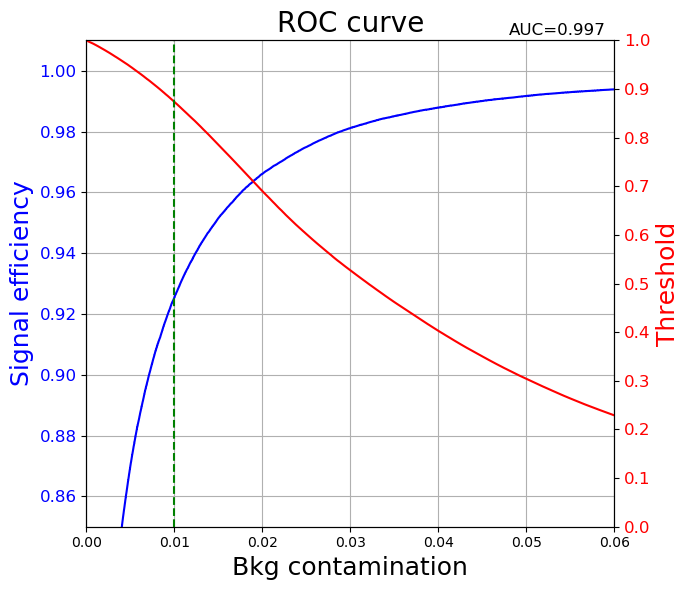

In [8]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

### Score histos

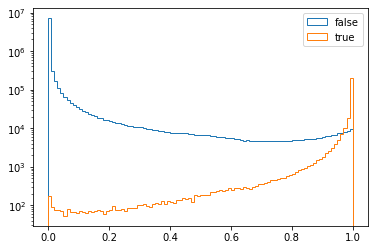

In [9]:
plt.hist(data_out["y"], bins=100, label="false", histtype="step")
plt.hist(data_in["y"], bins=100, label="true", histtype="step")
plt.yscale("log")
plt.legend()

# Plots
## Confusion matrix

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion(threshold, eta_bins, et_bins, axlim=(0.6, 0.2)):
    eta_min, eta_max = eta_bins
    et_min, et_max = et_bins
    data_out_0 = data_out[(data_out.y < threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                        (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ]
    data_out_1 = data_out[(data_out.y > threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                        (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ]
    data_in_0 = data_in[(data_in.y < threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                        (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ]
    data_in_1 = data_in[(data_in.y > threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                        (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ]
    nbins = 80
    
    fig = plt.figure(figsize=(7,8), dpi=200)

    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2, sharey = ax1)  #Share y-axes with subplot 1
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4, sharey = ax3)  #Share y-axes with subplot 1
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax4.get_yticklabels(), visible=False)
    
    #size = max([ data_out_0.size / 80**2, data_out_1.size / 80**2,data_in_0.size / 80**2, data_in_1.size / 80**2])
    
    h, *_, h11 = ax4.hist2d(data_in_1.cluster_dphi, data_in_1.cluster_deta,   
                    bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
    
    size = np.max(h)
    *_, h00= ax1.hist2d(data_out_0.cluster_dphi, data_out_0.cluster_deta,
                     bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), vmax=size, cmap="plasma", norm=colors.LogNorm())
    *_, h01 = ax2.hist2d(data_out_1.cluster_dphi, data_out_1.cluster_deta,  
                     bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), vmax=size,cmap="plasma", norm=colors.LogNorm())
    *_, h10 = ax3.hist2d(data_in_0.cluster_dphi, data_in_0.cluster_deta,  
                    bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), vmax=size,cmap="plasma", norm=colors.LogNorm())
    
    #fig.colorbar(h00, ax=ax[0][0])
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.delaxes(cax1)
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h01, cax=cax2, label="N. clusters")
    
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    fig.delaxes(cax3)
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h11, cax=cax4, label="N. clusters")
    
    ax1.set_ylabel("$\Delta \eta$")
    ax1.set_xlabel("$\Delta \phi$")
    ax2.set_xlabel("$\Delta \phi$")
    #ax2.set_ylabel("Delta Eta")
    ax3.set_ylabel("$\Delta \eta$")
    ax3.set_xlabel("$\Delta \phi$")
    ax4.set_xlabel("$\Delta \phi$")
    #ax4.set_ylabel("Delta Eta")

    ax1.set_xlim(-axlim[0], axlim[0])
    ax2.set_xlim(-axlim[0], axlim[0])
    ax3.set_xlim(-axlim[0], axlim[0])
    ax4.set_xlim(-axlim[0], axlim[0])
    ax1.set_ylim(-axlim[1], axlim[1])
    ax2.set_ylim(-axlim[1], axlim[1])
    ax3.set_ylim(-axlim[1], axlim[1])
    ax4.set_ylim(-axlim[1], axlim[1])
    
    plt.subplots_adjust(wspace = -.015, hspace=0.25)
    #plt.tight_layout()
    fig.text(0.5, 0.9, "Background", ha="center", va="center", fontsize="large")
    fig.text(0.5, 0.48, "Signal", ha="center", va="center",fontsize="large")
    fig.text(0.13, 0.89, f"Score < {threshold}", va="center")
    fig.text(0.13, 0.47, f"Score < {threshold}",va="center")
    fig.text(0.73, 0.89, f"Score > {threshold}", va="center")
    fig.text(0.73, 0.47, f"Score > {threshold}",va="center")
    
    fig.text(0.02, 0.93, f"${eta_min} < |\eta| < {eta_max}$, ${et_min} < E_{{T}}< {et_max}$", va="center", ha="left")

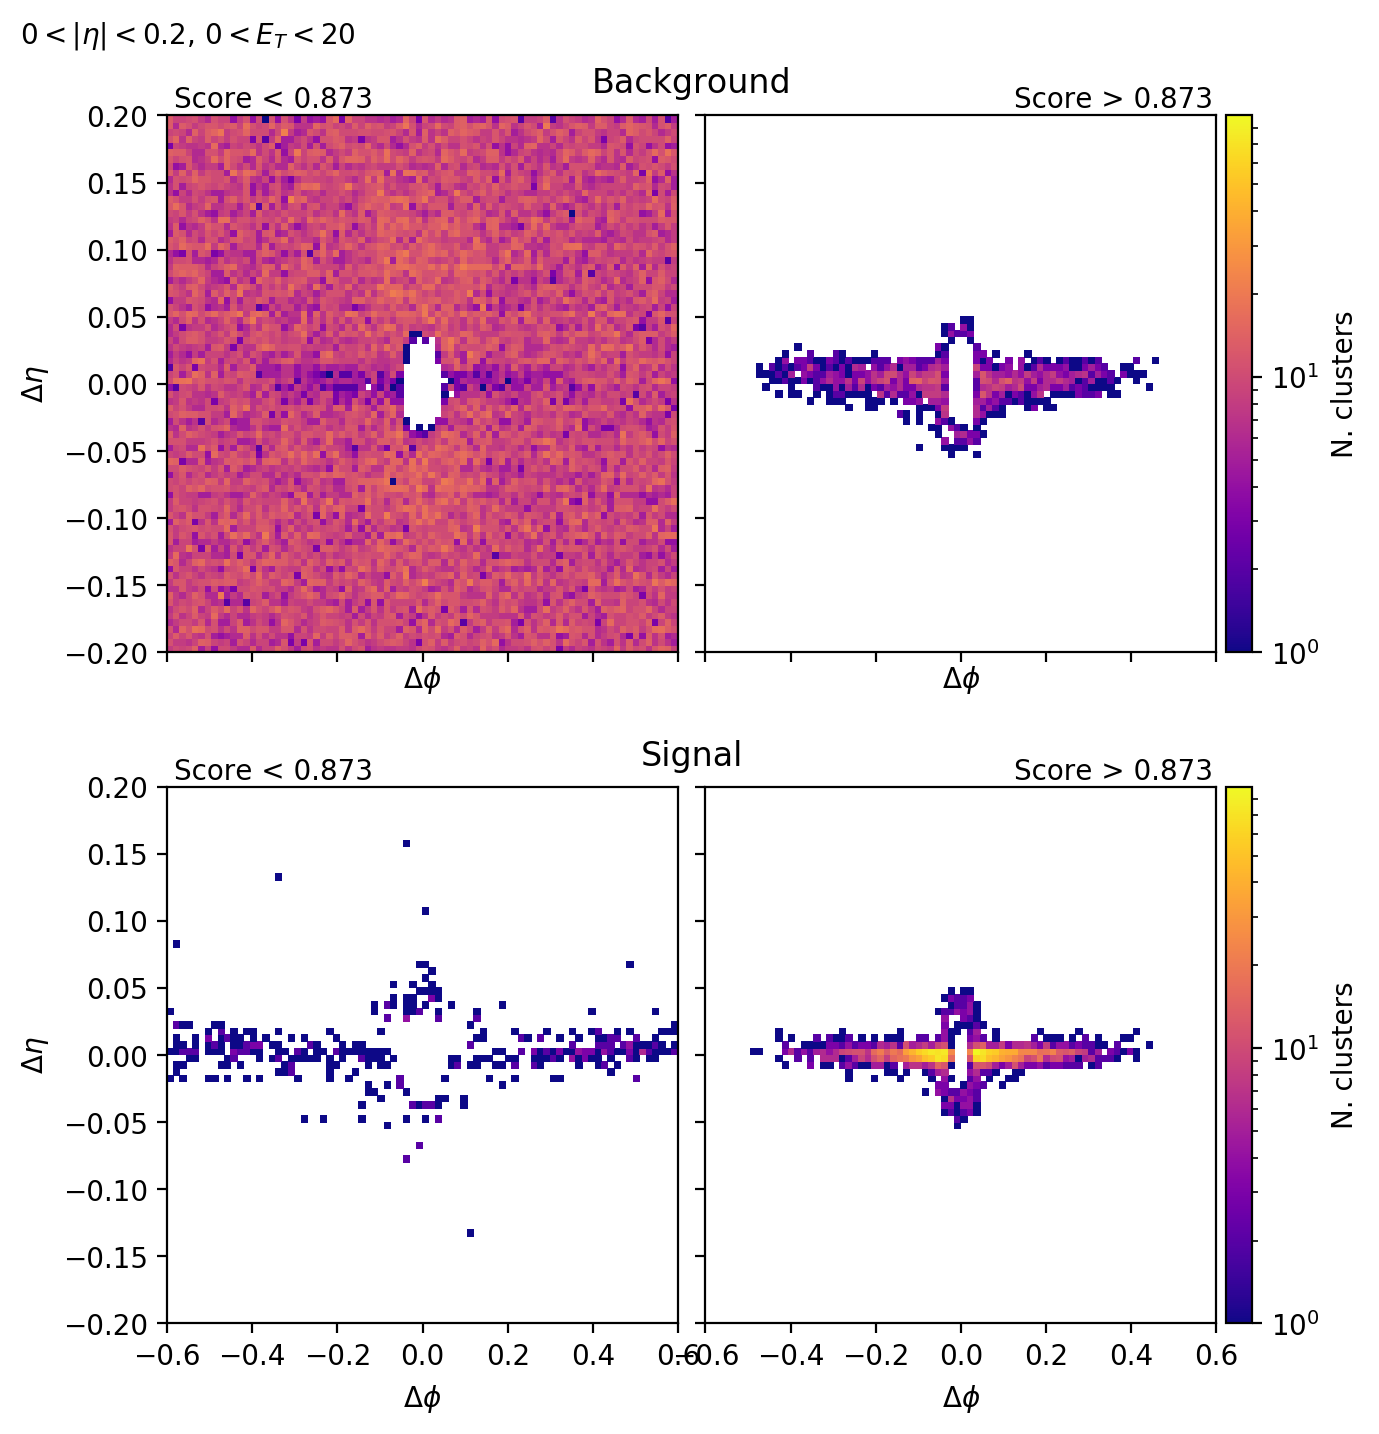

In [11]:
plot_confusion(0.873, (0,0.2), (0,20))

## Energy resolution plot

In [19]:
data_val.head()

,cluster_deta,cluster_dphi,cluster_iz,en_cluster,en_seed,en_true,in_scluster,index,is_calo,is_seed,max_dr_cluster,max_en_cluster,nclusters,seed_eta,seed_iz,seed_phi,window_index,y
0,0.00000,0.000000,0,89.952324,89.952324,90.506454,True,ddbsjtoi,True,True,0.000194,89.952324,1,0.689437,0,-1.350917,ddbsjtoi,0.999555
1,0.00000,0.000000,1,68.338326,68.338326,67.096359,True,cpdvcqoo,True,True,0.009782,68.338326,1,2.248480,1,0.383693,cpdvcqoo,0.999862
2,0.00000,0.000000,0,28.726391,28.726391,29.973450,True,pouiumgm,True,True,0.001420,28.726391,1,-0.291325,0,-0.438794,pouiumgm,0.999999
3,0.00000,0.000000,-1,4.413412,4.413412,12.939615,True,akiaspca,True,True,0.081994,4.413412,2,-1.516260,-1,0.173997,akiaspca,0.999961
4,-0.01952,0.193533,1,10.242984,68.338326,67.096359,False,cpdvcqoo,True,False,0.009782,68.338326,1,2.248480,1,0.383693,cpdvcqoo,0.970771


In [39]:
thresholds = [0.4,0.7,0.8,0.85, 0.873,0.9,0.95,0.99]

results = {}

for t in thresholds:

    g = data_val[(data_val.y >  t) | (data_val.is_seed==True)].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum', 
                          "en_true": "first", 
                          "en_seed": "first",
                          "seed_eta": "first",
                          "seed_phi": "first"})
    g["ratio"] = g["en_cluster"] / g["en_true"]
    
    results[t] = g

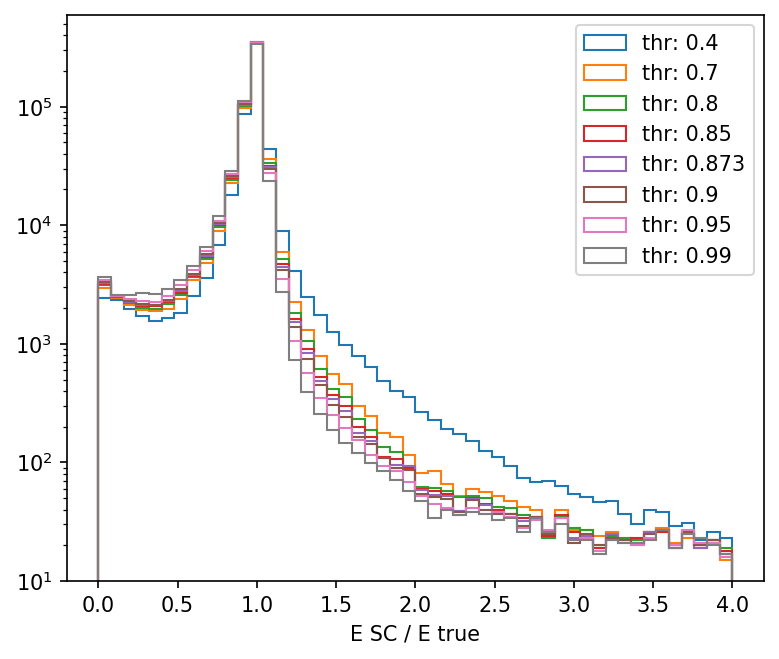

In [40]:
fig, _ = plt.subplots(figsize=(6,5), dpi=150)
for t , g in results.items():
    plt.hist(g.ratio, range=(0,4), bins=50,  histtype="step", label=f"thr: {t}", log=True, bottom=10)
plt.xlabel("E SC / E true")
plt.legend()

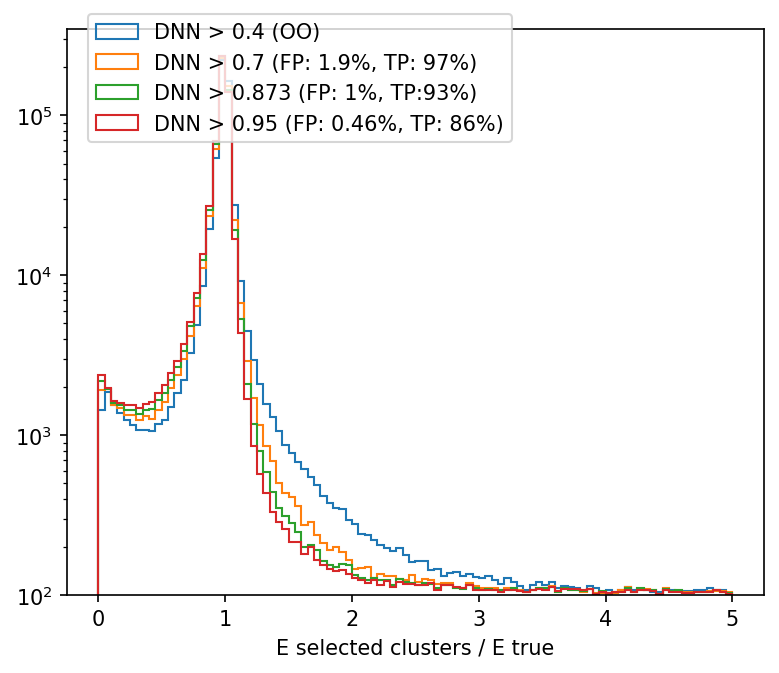

In [42]:
fig, ax = plt.subplots(figsize=(6,5), dpi=150)

info =    {
           0.7: "FP: 1.9%, TP: 97%", 
           0.873: "FP: 1%, TP:93%",
           0.95: "FP: 0.46%, TP: 86%"}

for t , g in results.items():
    if t  not in [0.4, 0.7, 0.873, 0.95]: continue
    ax.hist(g.ratio, range=(0,5), bins=100,  histtype="step", label=f"DNN > {t} ({info[t]})", log=True, bottom=1e2)
ax.set_xlabel("E selected clusters / E true")
ax.legend(loc=(0.03, 0.8))

## Energy resolution scan

In [36]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


t = 0.4
g = data_val[(data_val.y >  t) | (data_val.is_seed==True)].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum', 
                          "en_true": "min", 
                          "en_seed": "first",
                          "seed_eta": "first",
                          "seed_phi": "first"})
g["ratio"] = g["en_cluster"] / g["en_true"]
g["et_seed"] = g.en_seed / np.cosh(g.seed_eta)
g["eta_bin"] = pd.cut(abs(g.seed_eta), etas)
g["en_bin"] = pd.cut(g.et_seed, ens)

scanres = g.groupby(["eta_bin", "en_bin"]).agg({"ratio": ["mean", "std"], "en_cluster": "std", "en_true": "mean"})
scanres["res"] = scanres["en_cluster", "std"] / scanres["en_true", "mean"]
resolutions = np.reshape(scanres["res"].values, (len(etas)-1, len(ens)-1))

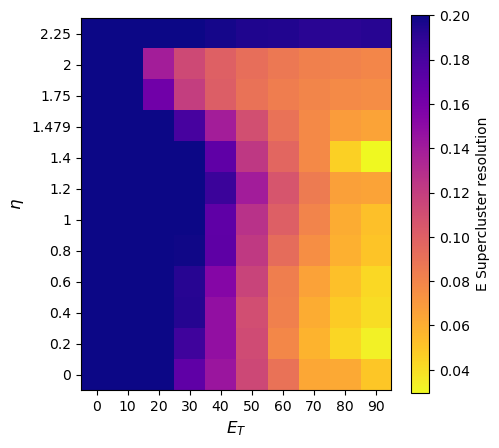

In [37]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)
im =  ax.imshow(resolutions, cmap="plasma_r", vmax=0.2)
ax.set_xticks(np.arange(len(ens)-1))
ax.set_yticks(np.arange(len(etas)-1))
ax.set_yticklabels(etas)
ax.set_xticklabels(ens)
ax.set_xlabel("$E_T$", fontsize="large")
ax.set_ylabel("$\eta$", fontsize="large")
plt.colorbar(im, ax=ax,label="E Supercluster resolution")

## Scores scan eta, en

In [25]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#etas = [0, 1, 2]
#ens= [0, 50, 100]
threshold = 0.873

results = np.zeros((len(etas)-1, len(ens)-1, 2))

data_in = data_in[data_in.is_seed==False]
data_out = data_out[data_out.is_seed==False]

for ieta in range(len(etas)-1):
    for ien in range(len(ens)-1):
        eta_min = etas[ieta]
        eta_max = etas[ieta+1]
        et_min = ens[ien]
        et_max = ens[ien+1]
        print(eta_min, eta_max, et_min, et_max)
        
        data_out_tot = data_out[(abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ].size
        data_out_1 = data_out[(data_out.y > threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ].size
        data_in_tot = data_in[ (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ].size
        data_in_1 = data_in[(data_in.y > threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ].size
        
        results[ieta, ien, :] = np.array([data_in_1 / data_in_tot , data_out_1 / data_out_tot])

0 0.2 0 10
0 0.2 10 20
0 0.2 20 30
0 0.2 30 40
0 0.2 40 50
0 0.2 50 60
0 0.2 60 70
0 0.2 70 80
0 0.2 80 90
0 0.2 90 100
0.2 0.4 0 10
0.2 0.4 10 20
0.2 0.4 20 30
0.2 0.4 30 40
0.2 0.4 40 50
0.2 0.4 50 60
0.2 0.4 60 70
0.2 0.4 70 80
0.2 0.4 80 90
0.2 0.4 90 100
0.4 0.6 0 10
0.4 0.6 10 20
0.4 0.6 20 30
0.4 0.6 30 40
0.4 0.6 40 50
0.4 0.6 50 60
0.4 0.6 60 70
0.4 0.6 70 80
0.4 0.6 80 90
0.4 0.6 90 100
0.6 0.8 0 10
0.6 0.8 10 20
0.6 0.8 20 30
0.6 0.8 30 40
0.6 0.8 40 50
0.6 0.8 50 60
0.6 0.8 60 70
0.6 0.8 70 80
0.6 0.8 80 90
0.6 0.8 90 100
0.8 1 0 10
0.8 1 10 20
0.8 1 20 30
0.8 1 30 40
0.8 1 40 50
0.8 1 50 60
0.8 1 60 70
0.8 1 70 80
0.8 1 80 90
0.8 1 90 100
1 1.2 0 10
1 1.2 10 20
1 1.2 20 30
1 1.2 30 40
1 1.2 40 50
1 1.2 50 60
1 1.2 60 70
1 1.2 70 80
1 1.2 80 90
1 1.2 90 100
1.2 1.4 0 10
1.2 1.4 10 20
1.2 1.4 20 30
1.2 1.4 30 40
1.2 1.4 40 50
1.2 1.4 50 60
1.2 1.4 60 70
1.2 1.4 70 80
1.2 1.4 80 90
1.2 1.4 90 100
1.4 1.479 0 10
1.4 1.479 10 20
1.4 1.479 20 30
1.4 1.479 30 40
1.4 1.479 40 50
1

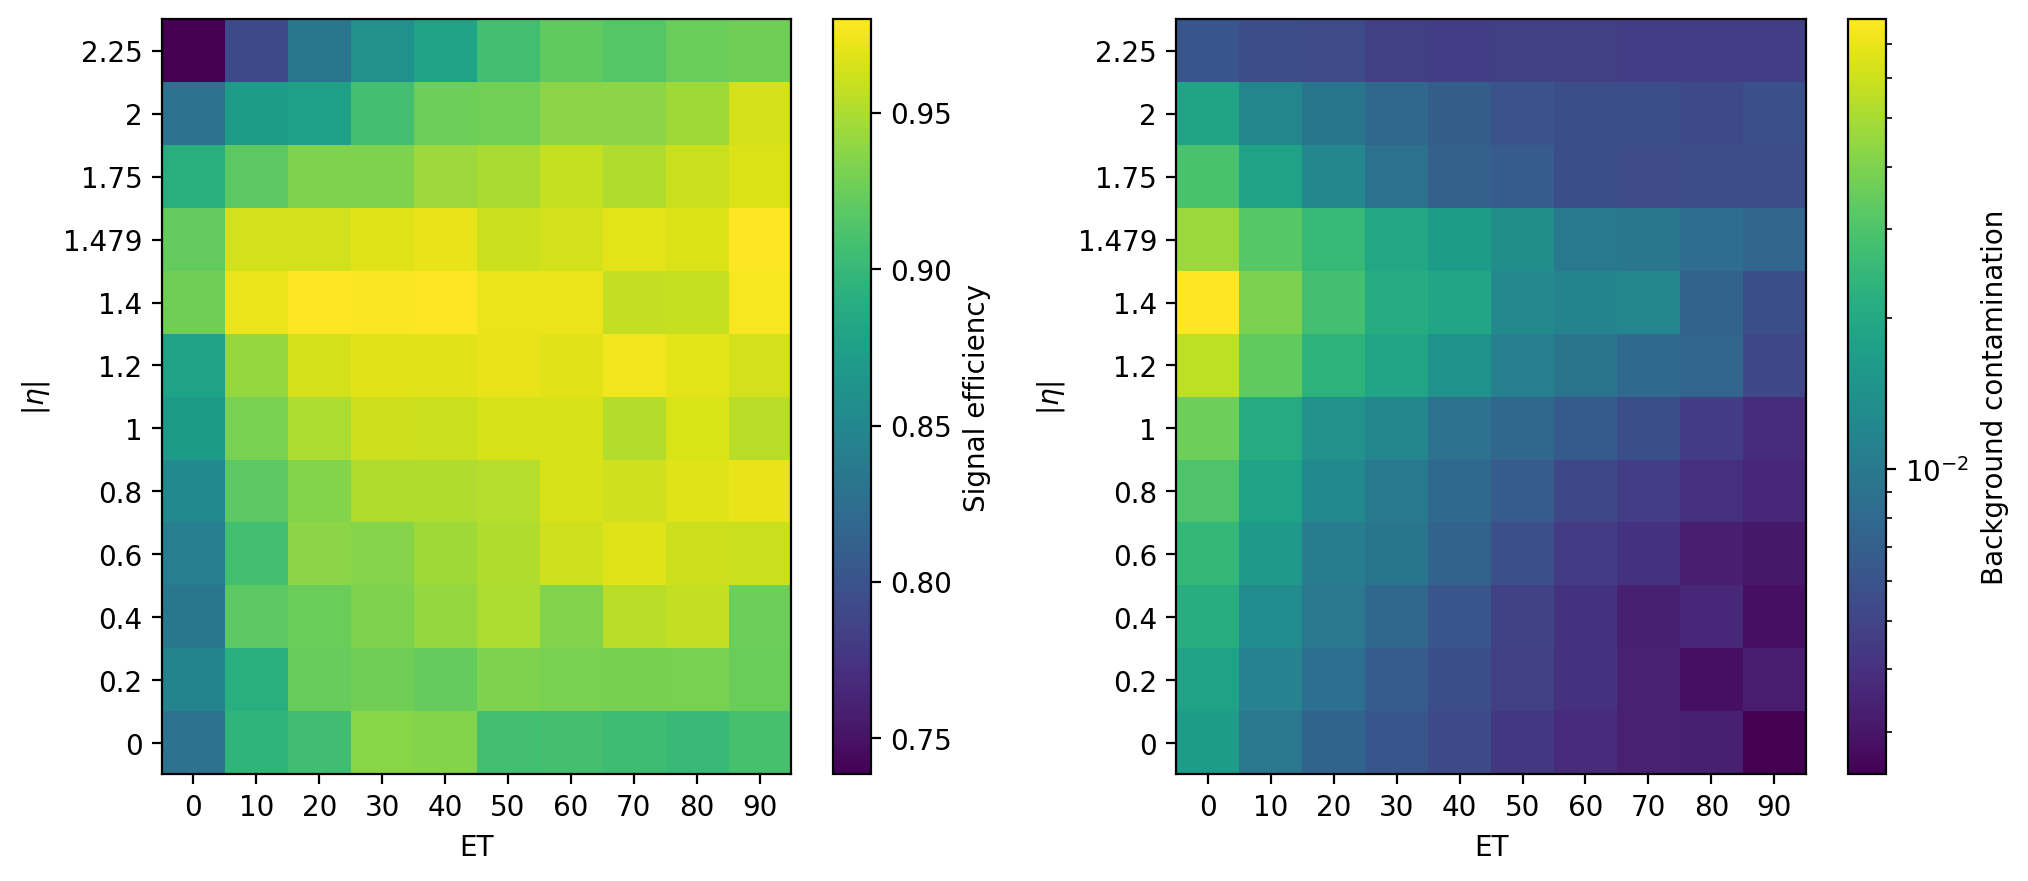

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12,5), dpi=200)
im = ax1.imshow(results[:,:,0])
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1, label="Signal efficiency")

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm())
ax2.set_xticks(np.arange(len(ens)-1))
ax2.set_yticks(np.arange(len(etas)-1))
ax2.set_yticklabels(etas)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET")
ax2.set_ylabel("$|\eta|$")
fig.colorbar(im2, ax=ax2, label="Background contamination")

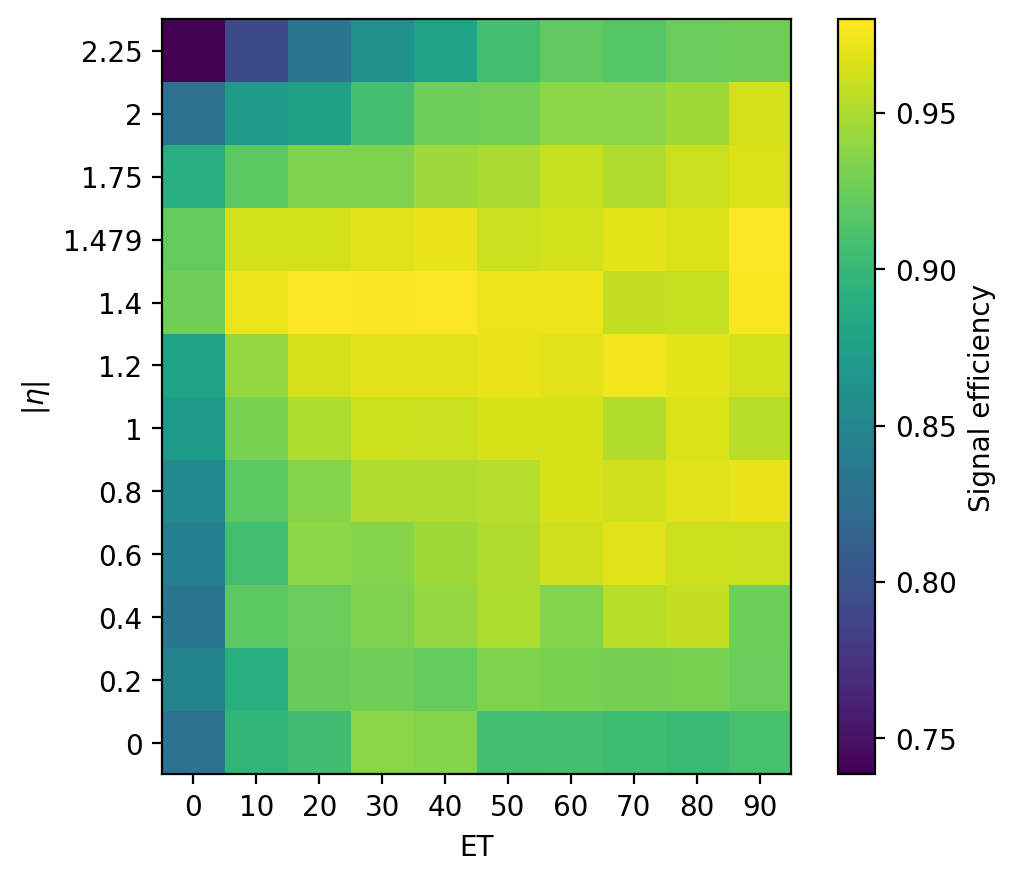

In [27]:
fig,ax1 = plt.subplots(figsize=(6,5), dpi=200)
im = ax1.imshow(results[:,:,0])
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1, label="Signal efficiency")


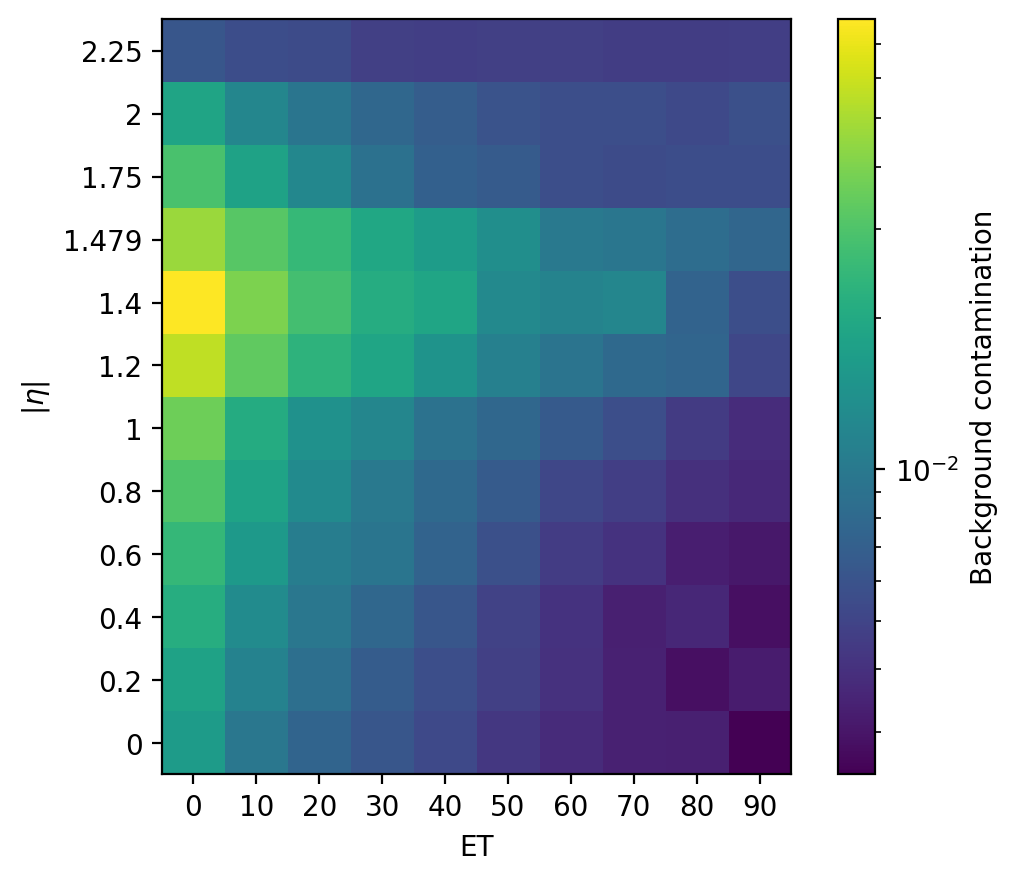

In [28]:
fig,ax2 = plt.subplots(figsize=(6,5), dpi=200)

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm())
ax2.set_xticks(np.arange(len(ens)-1))
ax2.set_yticks(np.arange(len(etas)-1))
ax2.set_yticklabels(etas)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET")
ax2.set_ylabel("$|\eta|$")
fig.colorbar(im2, ax=ax2, label="Background contamination")